In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pylab
import matplotlib as mpl
import scipy
import time
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dst

In [3]:
genes = []

def heatmap(x, row_header, column_header):
    
    """
    This below code is based in large part on the protype methods:
    http://old.nabble.com/How-to-plot-heatmap-with-matplotlib--td32534593.html
    http://stackoverflow.com/questions/7664826/how-to-get-flat-clustering-corresponding-to-color-clusters-in-the-dendrogram-cre

    x is an m by n ndarray, m observations, n genes
    """
    row_method = 'average'
    column_method = 'single'
    row_metric = 'cityblock' #cosine
    column_metric = 'euclidean'
    
    ### Define the color gradient to use based on the provided name
    n = len(x[0]); m = len(x)
    cmap=pylab.cm.viridis
    
    ### Scale the max and min colors so that 0 is white/black
    vmin=x.min()
    vmax=x.max()
    vmax = max([vmax,abs(vmin)])
    vmin = vmax*-1
    norm = mpl.colors.Normalize(vmin/2, vmax/2) ### adjust the max and min to scale these colors

    ### Scale the Matplotlib window size
    default_window_hight = 8.5
    default_window_width = 12
    fig = pylab.figure(figsize=(default_window_width,default_window_hight)) ### could use m,n to scale here
    color_bar_w = 0.015 ### Sufficient size to show
        
    ## calculate positions for all elements
    # ax1, placement of dendrogram 1, on the left of the heatmap
    #if row_method != None: w1 = 
    [ax1_x, ax1_y, ax1_w, ax1_h] = [0.05,0.22,0.2,0.6]   ### The second value controls the position of the matrix relative to the bottom of the view
    width_between_ax1_axr = 0.004
    height_between_ax1_axc = 0.004 ### distance between the top color bar axis and the matrix
    
    # axr, placement of row side colorbar
    [axr_x, axr_y, axr_w, axr_h] = [0.31,0.1,color_bar_w,0.6] ### second to last controls the width of the side color bar - 0.015 when showing
    axr_x = ax1_x + ax1_w + width_between_ax1_axr
    axr_y = ax1_y; axr_h = ax1_h
    width_between_axr_axm = 0.004

    # axc, placement of column side colorbar
    [axc_x, axc_y, axc_w, axc_h] = [0.4,0.63,0.5,color_bar_w] ### last one controls the hight of the top color bar - 0.015 when showing
    axc_x = axr_x + axr_w + width_between_axr_axm
    axc_y = ax1_y + ax1_h + height_between_ax1_axc
    height_between_axc_ax2 = 0.004

    # axm, placement of heatmap for the data matrix
    [axm_x, axm_y, axm_w, axm_h] = [0.4,0.9,2.5,0.5]
    axm_x = axr_x + axr_w + width_between_axr_axm
    axm_y = ax1_y; axm_h = ax1_h
    axm_w = axc_w

    # ax2, placement of dendrogram 2, on the top of the heatmap
    [ax2_x, ax2_y, ax2_w, ax2_h] = [0.3,0.72,0.6,0.15] ### last one controls hight of the dendrogram
    ax2_x = axr_x + axr_w + width_between_axr_axm
    ax2_y = ax1_y + ax1_h + height_between_ax1_axc + axc_h + height_between_axc_ax2
    ax2_w = axc_w

    # axcb - placement of the color legend
    [axcb_x, axcb_y, axcb_w, axcb_h] = [0.07,0.88,0.18,0.09]

    # Compute and plot top dendrogram
    start_time = time.time()
    d2 = dst.pdist(x.T)
    D2 = dst.squareform(d2)
    ax2 = fig.add_axes([ax2_x, ax2_y, ax2_w, ax2_h], frame_on=True)
    Y2 = sch.linkage(D2, method=column_method, metric=column_metric) ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
    Z2 = sch.dendrogram(Y2)
    ind2 = sch.fcluster(Y2,0.7*max(Y2[:,2]),'distance') ### This is the default behavior of dendrogram
    ax2.set_xticks([]) ### Hides ticks
    ax2.set_yticks([])
    time_diff = str(round(time.time()-start_time,1))
    print('Column clustering completed in %s seconds' % time_diff)
        
    # Compute and plot left dendrogram.
    start_time = time.time()
    d1 = dst.pdist(x)
    D1 = dst.squareform(d1)  # full matrix
    ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h], frame_on=True) # frame_on may be False
    Y1 = sch.linkage(D1, method=row_method, metric=row_metric) ### gene-clustering metric - 'average', 'single', 'centroid', 'complete'
    Z1 = sch.dendrogram(Y1, orientation='right')
    ind1 = sch.fcluster(Y1,0.7*max(Y1[:,2]),'distance') ### This is the default behavior of dendrogram
    ax1.set_xticks([]) ### Hides ticks
    ax1.set_yticks([])
    time_diff = str(round(time.time()-start_time,1))
    print('Row clustering completed in %s seconds' % time_diff)
        
    # Plot distance matrix.
    axm = fig.add_axes([axm_x, axm_y, axm_w, axm_h])  # axes for the data matrix
    xt = x
    
    idx2 = Z2['leaves'] ### apply the clustering for the array-dendrograms to the actual matrix data
    xt = xt[:,idx2]
    ind2 = ind2[idx2] ### reorder the flat cluster to match the order of the leaves the dendrogram
    
    idx1 = Z1['leaves'] ### apply the clustering for the gene-dendrograms to the actual matrix data
    xt = xt[idx1,:]   # xt is transformed x
    ind1 = ind1[idx1] ### reorder the flat cluster to match the order of the leaves the dendrogram
        
    ### taken from http://stackoverflow.com/questions/2982929/plotting-results-of-hierarchical-clustering-ontop-of-a-matrix-of-data-in-python/3011894#3011894
    im = axm.matshow(xt, aspect='auto', origin='lower', cmap=cmap, norm=norm) ### norm=norm added to scale coloring of expression with zero = white or black
    axm.set_xticks([]) ### Hides x-ticks
    axm.set_yticks([])

    # Add text
    new_row_header=[]
    new_column_header=[]
    for i in range(x.shape[0]):
        if row_method != None:
            genes.append(row_header[idx1[i]])
            if len(row_header)<100: ### Don't visualize gene associations when more than 100 rows
                axm.text(x.shape[1]-0.5, i, '  '+row_header[idx1[i]])
            new_row_header.append(row_header[idx1[i]])
        else:
            if len(row_header)<100: ### Don't visualize gene associations when more than 100 rows
                axm.text(x.shape[1]-0.5, i, '  '+row_header[i]) ### When not clustering rows
            new_row_header.append(row_header[i])
    for i in range(x.shape[1]):
        if column_method != None:
            axm.text(i, -0.9, ' '+column_header[idx2[i]], rotation=270, size=9, verticalalignment="top") # rotation could also be degrees
            new_column_header.append(column_header[idx2[i]])
        else: ### When not clustering columns
            axm.text(i, -0.9, ' '+column_header[i], rotation=270, verticalalignment="top")
            new_column_header.append(column_header[i])

    # Plot colside colors
    # axc --> axes for column side colorbar
    axc = fig.add_axes([axc_x, axc_y, axc_w, axc_h])  # axes for column side colorbar
    cmap_c = mpl.colors.ListedColormap(['r', 'g', 'b', 'y', 'w', 'k', 'm'])
    dc = np.array(ind2, dtype=int)
    dc.shape = (1,len(ind2)) 
    im_c = axc.matshow(dc, aspect='auto', origin='lower', cmap=cmap_c)
    axc.set_xticks([]) ### Hides ticks
    axc.set_yticks([])
    
    # Plot rowside colors
    # axr --> axes for row side colorbar
    axr = fig.add_axes([axr_x, axr_y, axr_w, axr_h])  # axes for column side colorbar
    dr = np.array(ind1, dtype=int)
    dr.shape = (len(ind1),1)
    #print ind1, len(ind1)
    cmap_r = mpl.colors.ListedColormap(['r', 'g', 'b', 'y', 'w', 'k', 'm'])
    im_r = axr.matshow(dr, aspect='auto', origin='lower', cmap=cmap_r)
    axr.set_xticks([]) ### Hides ticks
    axr.set_yticks([])

    # Plot color legend
    axcb = fig.add_axes([axcb_x, axcb_y, axcb_w, axcb_h], frame_on=False)  # axes for colorbar
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='horizontal')
    axcb.set_title("colorkey")
    
    ### Render the graphic
    if len(row_header)>50 or len(column_header)>50:
        pylab.rcParams['font.size'] = 5
    else:
        pylab.rcParams['font.size'] = 8

    pylab.show()

In [4]:
ce = pd.read_csv('../data/CE_exp.umi.tab', sep='\t', skipfooter=5)
ce

/home/ilya/.venv/pydata3/lib/python3.5/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,#Sample:,CE_1.genome,CE_10.genome,CE_2.genome,CE_3.genome,CE_4.genome,CE_5.genome,CE_6.genome,CE_7.genome,CE_8.genome,CE_9.genome
0,2L52.1,0,0,1,0,0,0,1,0,0,1
1,2L52.2,0,0,0,0,0,0,0,0,0,0
2,2RSSE.1,0,0,0,0,0,0,0,0,0,0
3,2RSSE.2,0,0,0,0,0,0,0,0,0,0
4,2RSSE.3,0,0,0,0,0,0,0,0,0,0
5,2RSSE.4,0,0,0,0,0,0,0,0,0,0
6,2RSSE.5,0,0,0,0,0,0,0,0,0,0
7,2RSSE.6,0,0,0,0,0,0,0,0,0,0
8,2RSSE.7,0,0,0,0,0,0,0,0,0,0
9,2RSSE.8,0,0,0,0,0,0,0,0,0,0


In [5]:
X = ce.ix[ce.ix[:,1:].mean(axis=1)>100,1:].values
row_header = ce.ix[ce.ix[:,1:].mean(axis=1)>100,0].tolist()

/home/ilya/.venv/pydata3/lib/python3.5/site-packages/ipykernel/__main__.py:73: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


Column clustering completed in 0.1 seconds


/home/ilya/.venv/pydata3/lib/python3.5/site-packages/ipykernel/__main__.py:86: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


Row clustering completed in 14.3 seconds


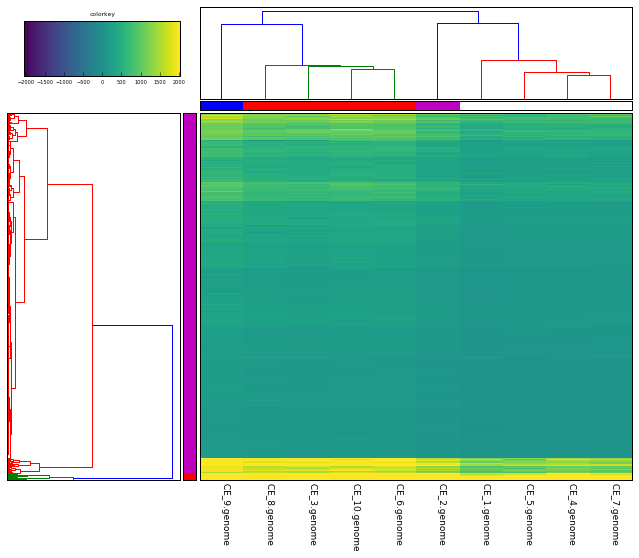

In [6]:
heatmap(X, row_header, ce.columns.tolist()[1:])